In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import time
import unicodedata

from selenium import webdriver
from selenium.webdriver.chrome.options import Options  

In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
datetime.now()

datetime.datetime(2020, 7, 8, 15, 10, 12, 58631)

In [4]:
url = 'https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-current-situation-and-case-numbers'


driver.get(url)



In [5]:
content = driver.page_source

In [6]:
date_time_str = re.search('(\d+ \w+ 202\d)' ,str(content)).group(1)
date_time_str

'08 July 2020'

In [7]:
data_date_time = datetime.strptime(date_time_str, '%d %B %Y').strftime('%Y-%m-%d')
data_date_time

'2020-07-08'

### Dataframe

In [8]:
for i in range(40): # retry and wait till the tables are loaded
    try:
        dfs = pd.read_html(driver.page_source)
        if len(dfs)>0:
            break
    except ValueError as e:
        print(e)
    time.sleep(1)
dfs

No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found


[  Jurisdiction  Total confirmed cases  New cases in last 24 hours  Deaths
 0    Australia                   8886                         147     106
 1          ACT                    111                           3       3
 2          NSW                   3440                           8      49
 3           NT                     30                           0       0
 4          QLD                   1068                           0       6
 5           SA                    443                           0       4
 6          TAS                    228                           0      13
 7          VIC                   2942                         134      22
 8           WA                    624                           2       9,
    Unnamed: 0                           Source of Infection  Cases      %
 0         NaN                                      Overseas   4973  56.0%
 1         NaN  Locally acquired - contact of confirmed case   2612  29.4%
 2         NaN     Local

In [9]:
df = dfs[0]
df = df.iloc[:,0:2].T 
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df


Jurisdiction,Australia,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
Total confirmed cases,8886,111,3440,30,1068,443,228,2942,624


In [10]:


df.insert(0, 'date', data_date_time)
df = df.rename(columns={
    'Australia':'australia',
    'ACT':'act',
    'NSW':'nsw',
    'QLD':'qld',
    'SA':'sa',
    'TAS':'tas',
    'VIC':'victoria',
    'WA':'wa',
    'NT':'nt',
})
df

Jurisdiction,date,australia,act,nsw,nt,qld,sa,tas,victoria,wa
Total confirmed cases,2020-07-08,8886,111,3440,30,1068,443,228,2942,624


In [11]:
assert int(df['australia'])>0

In [12]:
df

Jurisdiction,date,australia,act,nsw,nt,qld,sa,tas,victoria,wa
Total confirmed cases,2020-07-08,8886,111,3440,30,1068,443,228,2942,624


### Save to file

In [13]:
from pathlib import Path
csv_file = '../data/australia-cases.csv'

if Path(csv_file).exists():
    # read out the old data
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['date'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [14]:
df.sort_values(by=['date'], inplace=True)
df.to_csv(csv_file, index=False)
df

,act,australia,date,nsw,nt,qld,sa,tas,victoria,wa
0,NaN,12,2020-02-04,4,NaN,2,2,NaN,4,NaN
1,NaN,13,2020-02-05,4,NaN,3,2,NaN,4,NaN
2,NaN,14,2020-02-06,4,NaN,4,2,NaN,4,NaN
3,NaN,15,2020-02-07,4,NaN,5,2,NaN,4,NaN
4,NaN,15,2020-02-08,4,NaN,5,2,NaN,4,NaN
...,...,...,...,...,...,...,...,...,...,...
150,108,8362,2020-07-04,3405,30,1067,443,228,2469,612
151,108,8449,2020-07-05,3419,30,1067,443,228,2536,618
152,108,8586,2020-07-06,3429,30,1067,443,228,2660,621
153,108,8755,2020-07-07,3433,30,1068,443,228,2824,621


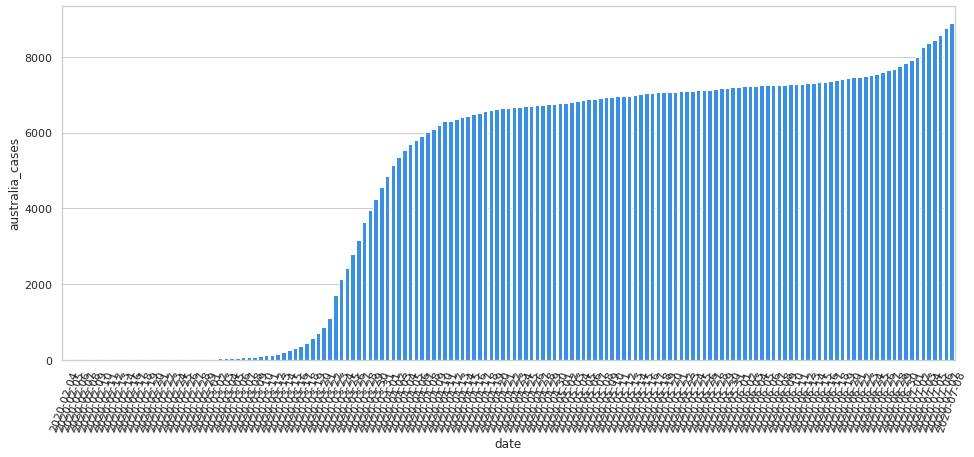

In [15]:
# plot
df['australia_cases']= df['australia'].apply(lambda x: int(x))

import seaborn as sns


sns.set(rc={'figure.figsize':(16,6.5)})
sns.set(style="whitegrid")


bar_chart = sns.barplot(x='date', y='australia_cases', color='dodgerblue', data=df)
bar_chart.tick_params(axis='x', labelrotation=70)


In [16]:
png_file = '../images/australia-cases.png'
bar_chart_fig = bar_chart.get_figure()
bar_chart_fig.savefig(png_file)
